In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale=1.8, style="ticks")


In [2]:
year2result = defaultdict(dict)
month="02"
for subtype in ("h1n1", "h3n2"):
    for year in range(2012, 2022):
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        if not os.path.exists(vaccine_scores_path):
            continue
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    year2result[subtype][year] = our_model
    


In [3]:
subtype_counting = pd.read_csv("../../data/flu_hospitalizations/subtype_count_per_year.csv")

year2subtype_counting = defaultdict(dict)

for subtype, count, year in zip(subtype_counting["subtype"], subtype_counting["num"], subtype_counting["year"]):
    subtype = subtype.split("/")[-1].strip().lower()
    year2subtype_counting[year][subtype] = count
print(year2subtype_counting)

defaultdict(<class 'dict'>, {2010: {'h1n1': 3496, 'h3n2': 1829, 'b': 1640}, 2009: {'h1n1': 7772, 'h3n2': 387, 'b': 702}, 2018: {'h1n1': 10846, 'b': 2173, 'h3n2': 10919}, 2019: {'h1n1': 9113, 'b': 8457, 'h3n2': 6148}, 2021: {'b': 1354, 'h3n2': 13892, 'h1n1': 915}, 2020: {'b': 747, 'h3n2': 440, 'h1n1': 234}, 2014: {'h1n1': 1809, 'h3n2': 7363, 'b': 2368}, 2015: {'h1n1': 8319, 'h3n2': 2779, 'b': 4674}, 2017: {'h1n1': 5576, 'b': 9155, 'h3n2': 10251}, 2013: {'h1n1': 3000, 'h3n2': 2186, 'b': 1350}, 2022: {'h3n2': 12177, 'b': 1701, 'h1n1': 6351}, 2012: {'b': 2141, 'h1n1': 2162, 'h3n2': 3220}, 2016: {'h1n1': 1620, 'h3n2': 18966, 'b': 3587}, 2011: {'h1n1': 817, 'h3n2': 2630, 'b': 1387}})


In [4]:
ref_vaccine_scores = []
ref_vaccine_scores_gt = []
ref_source = []
ref_subtype = []
ref_ve = []
ref_years = []

for subtype in year2result:
    for year in year2result[subtype]:
    
        ref_vaccine_score_pred = []
        ref_vaccine_score_gt = []
        # gt_score_clade score gt_score_seq coverage_clade
        for gt_score_clade, score, name, coverage in zip(year2result[subtype][year]["gt_score_seq"], year2result[subtype][year]["score"], year2result[subtype][year]["strain_name"], year2result[subtype][year]["coverage_seq"]):
            if coverage < 0.4:
                continue
            ref_vaccine_score_pred.append(score)
            ref_vaccine_score_gt.append(gt_score_clade)

        if len(ref_vaccine_score_pred) > 0:
            ref_vaccine_score = [x  for x in ref_vaccine_score_pred if not np.isnan(x)]
            if len(ref_vaccine_score) > 0:
                ref_vaccine_scores.append(np.median(ref_vaccine_score))
                ref_source.append("Prediction")
                ref_subtype.append(subtype)
                ref_years.append(year)

            ref_vaccine_score_gt = [x  for x in ref_vaccine_score_gt if not np.isnan(x)]
            if len(ref_vaccine_score_gt) > 0:
                ref_vaccine_scores.append(np.median(ref_vaccine_score_gt))
                ref_source.append("Ground-truth")
                ref_subtype.append(subtype)
                ref_years.append(year)



In [5]:
ref_vaccine_scores = np.asarray(ref_vaccine_scores)
d = {'escapability score': - ref_vaccine_scores, 'subtype': ref_subtype, '': ref_source, "year": ref_years}
res = pd.DataFrame(data=d)

print(res)

    escapability score subtype                year
0            -0.092916    h1n1    Prediction  2012
1            -0.562737    h1n1  Ground-truth  2012
2            -0.501977    h1n1    Prediction  2013
3            -0.250154    h1n1  Ground-truth  2013
4            -0.265660    h1n1    Prediction  2014
5            -0.344834    h1n1  Ground-truth  2014
6            -0.238557    h1n1    Prediction  2015
7            -0.373636    h1n1  Ground-truth  2015
8            -0.363233    h1n1    Prediction  2016
9            -0.718251    h1n1  Ground-truth  2016
10           -0.123189    h1n1    Prediction  2017
11           -0.361745    h1n1  Ground-truth  2017
12           -0.317669    h1n1    Prediction  2018
13           -0.637738    h1n1  Ground-truth  2018
14           -0.598433    h1n1    Prediction  2019
15           -2.050202    h1n1  Ground-truth  2019
16           -0.652660    h1n1    Prediction  2020
17           -0.394237    h1n1  Ground-truth  2020
18           -4.230350    h1n1 

In [6]:
method_year2score = dict()

for method in ("Prediction", "Ground-truth"):
    year2score = defaultdict(float)
    _res = res[res[""] == method]
    for year, subtype, score in zip(_res["year"], _res["subtype"], _res["escapability score"]):
        subtype_count = year2subtype_counting[year][subtype]
        year2score[year]+=((subtype_count * score) / (year2subtype_counting[year]["h1n1"] + year2subtype_counting[year]["h3n2"]))
    method_year2score[method] = year2score

In [8]:
averted_df = pd.read_csv("../../data/flu_hospitalizations/averted_burden.csv")
averted_df["year"] = np.asarray([int(x.split("-")[0]) for x in averted_df["Season"]], np.int64)

for metric in ("Averted Symptomatic Illnesses", "Averted Medical Visits"):
    averted_df[metric] = np.asarray([x.replace(",", "") for x in averted_df[metric]], dtype=np.float32) 

for method in ("Prediction", "Ground-truth"):
    averted_df[method] = [method_year2score[method].get(year, np.nan) for year in averted_df["year"]]
print(averted_df)


       Season  Averted Symptomatic Illnesses                   95% UI  \
0   2010-2011                      5600000.0  (3,100,000, 14,000,000)   
1   2011-2012                      2200000.0    (830,000, 12,000,000)   
2   2012-2013                      5500000.0  (3,700,000, 11,000,000)   
3   2013-2014                      7500000.0  (4,300,000, 12,000,000)   
4   2014-2015                      1400000.0       (8,300, 4,200,000)   
5   2015-2016                      5300000.0   (2,500,000, 9,200,000)   
6   2016-2017                      5300000.0  (2,400,000, 11,000,000)   
7   2017-2018                      5900000.0   (4,700,000, 7,400,000)   
8   2018-2019                      3100000.0   (2,400,000, 4,700,000)   
9   2019-2020                      7000000.0   (5,400,000, 8,900,000)   
10  2021-2022                      1800000.0   (1,000,000, 2,800,000)   

    Averted Medical Visits                 95% UI.1 Averted Hospitalizations  \
0                2800000.0   (1,700,000, 6,

/data/rsg/nlp/wenxian/miniconda3/envs/torchlit/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


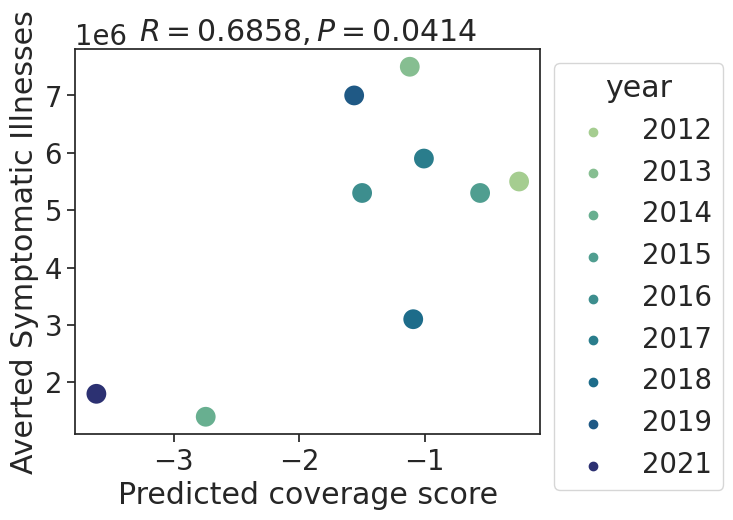

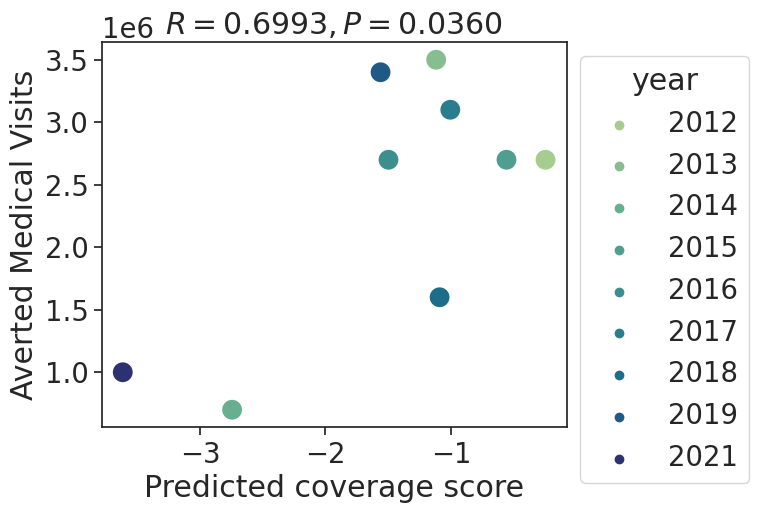

In [9]:
_averted_df = averted_df[~np.isnan(averted_df["Prediction"]) ]
_averted_df = _averted_df[~np.isnan(averted_df["Ground-truth"])]

# _averted_df = _averted_df[_averted_df["year"] > 2012]

_averted_df["Year"] = ["_%s" % x if x not in ('2013', '2021') else x for x in _averted_df["year"]]


model = "Prediction"

for i, metric in enumerate(("Averted Symptomatic Illnesses", "Averted Medical Visits")):
    plt.figure(figsize=(6, 5))
    
    ax = sns.scatterplot(_averted_df, y=metric, x=model, hue="year", s=240, palette="crest", legend="full") # 
#     ax = sns.lineplot(y = fitline_ys, x = fitline_xs,linewidth=1.9, ax=ax) # ci = 95) # , ci=95

    ax.set_ylabel(metric)
    ax.set_xlabel("Predicted coverage score")
    
    rho, rho_p = stats.spearmanr(_averted_df[metric], _averted_df[model])
    r, r_p = stats.pearsonr(_averted_df[metric], _averted_df[model])
    
    ax.set_title(f"$R=%.4lf,P=%.4lf$" % (r, r_p))
    
    if i < 0:
        plt.legend([],[], frameon=False)
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
    plt.savefig("figs/%s_with_score_prediction.pdf" % (metric.lower().replace(" ", "_")), format='pdf', bbox_inches='tight')
    
    plt.show()

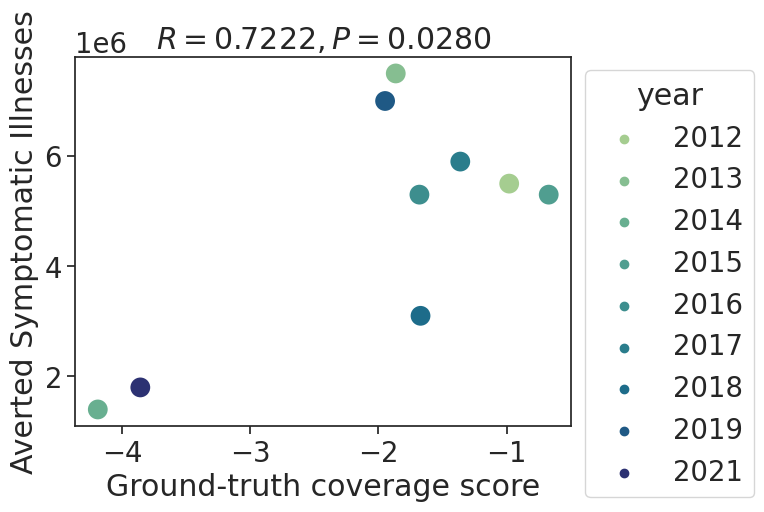

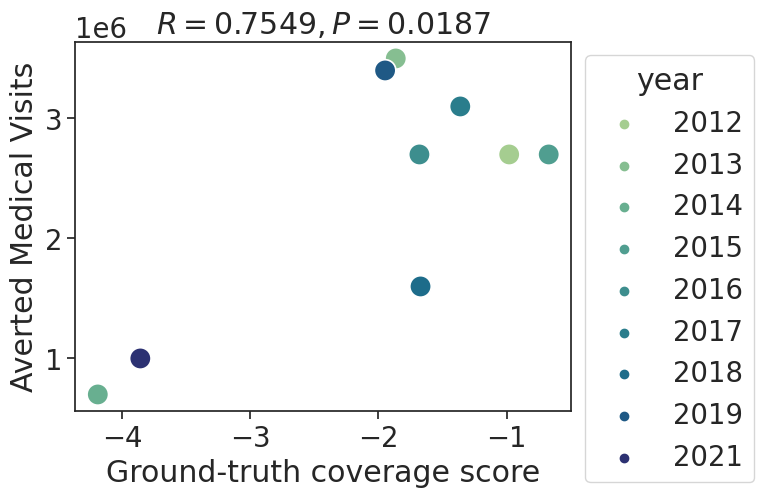

In [10]:
model = "Ground-truth"

for metric in ("Averted Symptomatic Illnesses", "Averted Medical Visits"):
    ax = sns.scatterplot(_averted_df, y=metric, x=model, hue="year", legend="full", s=240, palette="crest")
    ax.set_ylabel(metric)
    ax.set_xlabel("Ground-truth coverage score")
    
    rho, rho_p = stats.spearmanr(_averted_df[metric], _averted_df[model])
    r, r_p = stats.pearsonr(_averted_df[metric], _averted_df[model])
    
    ax.set_title(f"$R=%.4lf,P=%.4lf$" % (r, r_p))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig("figs/%s_with_score_gt.pdf" % (metric.lower().replace(" ", "_")), format='pdf', bbox_inches='tight')
    plt.show()